In [36]:
import albumentations as alb
import cv2
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_wd = Path('/data') / 'raspi_face_detection'
img_path = data_wd / 'images'
labels_path = data_wd / 'labels'

model_sets_path = data_wd / 'model_sets'

### 4.1 Setup Albumentations Transform Pipeline

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [11]:
folder = 'train'
model_set_filepath = model_sets_path / folder
model_set_filepath_images = model_set_filepath / 'images'
model_set_filepath_labels = model_set_filepath / 'labels'
fns = list(model_set_filepath_images.glob('*'))
# fn = fns[1].stem
fn = '49e246c6-0968-11ef-b027-dca632a68397'
fn

'49e246c6-0968-11ef-b027-dca632a68397'

In [12]:
model_sets_path

PosixPath('/data/raspi_face_detection/model_sets')

In [15]:
img_fn   = model_set_filepath_images / f'{fn}.jpg'
label_fn = model_set_filepath_labels / f'{fn}.json'

In [16]:
img = cv2.imread(str(img_fn))
print(('height', 'width', 'layers'))
img.shape

('height', 'width', 'layers')


(480, 640, 3)

In [19]:
with open(label_fn, 'r') as f:
    label = json.load(f)

In [20]:
label.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [25]:
shapes, coords, labels = label['shapes'], list(), list()
for shape in shapes:
    c = [0,0,0.00001,0.00001]
    c[0] = shape['points'][0][0]
    c[1] = shape['points'][0][1]
    c[2] = shape['points'][1][0]
    c[3] = shape['points'][1][1]
    c = list(np.divide(c, [640,480,640,480]))

    labels.append(shape['label'])
    coords.append(c)
coords, labels

([[0.3280038759689923,
   0.2678456072351422,
   0.5006056201550387,
   0.5294735142118864],
  [0.11543120155038762,
   0.06597222222222227,
   0.2704699612403101,
   0.3235626614987081]],
 ['kara', 'brendan'])

### 4.4 Apply Augmentations and View Results

In [26]:
augmented = augmentor(image=img, bboxes=coords, class_labels=labels)

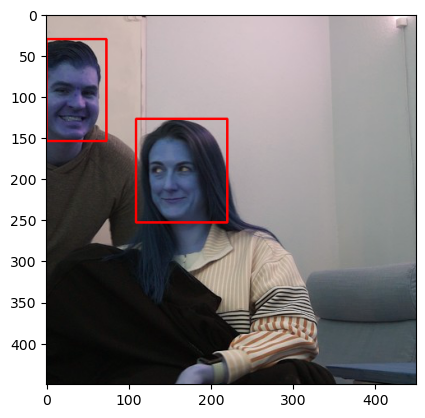

In [29]:
for bbox in augmented['bboxes']:
    cv2.rectangle(augmented['image'], 
                  tuple(np.multiply(bbox[:2], [450,450]).astype(int)),
                  tuple(np.multiply(bbox[2:], [450,450]).astype(int)), 
                        (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

In [57]:
aug_sets_path = data_wd / 'aug_data'

In [58]:
image

PosixPath('/data/raspi_face_detection/model_sets/train/images/d94ab6e2-0cbd-11ef-9a53-dca632a68397.jpg')

### 5.1 Run Augmentation Pipeline

In [60]:
class_nums = dict(brendan=1, kara=2)

for partition in ['train','test','val']: 
    model_set_filepath = model_sets_path / partition
    model_set_filepath_images = model_set_filepath / 'images'
    model_set_filepath_labels = model_set_filepath / 'labels'

    aug_set_filepath = aug_sets_path / partition
    aug_set_filepath_images = aug_set_filepath / 'images'
    aug_set_filepath_labels = aug_set_filepath / 'labels'
    
    for image in list(model_set_filepath_images.glob('*')):
        img_path = model_set_filepath_images / image
        img = cv2.imread(str(img_path))

        label_path = model_set_filepath_labels / f'{img_path.stem}.json'
        if label_path.is_file():
            with open(label_path, 'r') as f:
                label = json.load(f)

        shapes, coords, labels = label['shapes'], list(), list()
        shapes.sort(key=lambda x: x['label'])
        for shape in shapes:
            c = [0,0,0.00001,0.00001]
            c[0] = shape['points'][0][0]
            c[1] = shape['points'][0][1]
            c[2] = shape['points'][1][0]
            c[3] = shape['points'][1][1]
            c = list(np.divide(c, [640,480,640,480]))
        
            labels.append(shape['label'])
            coords.append(c)


        for x in range(60):
            augmented = augmentor(image=img, bboxes=coords, class_labels=labels)
            aug_image, aug_labels, aug_bboxes = augmented['image'], augmented['class_labels'], augmented['bboxes']
            
            cv2.imwrite(str(aug_set_filepath_images / f'{img_path.stem}_{x}.jpg'), aug_image)

            annotation = {}
            annotation['image'] = str(image)

            if not label_path.is_file() or len(aug_labels) == 0: 
                annotation['bboxes'] = [[0,0,0,0], [0,0,0,0]]
                annotation['classes'] = [0] 
            else:
                if len(aug_labels) == 1:
                    if aug_labels[0] == 'kara':
                        aug_bboxes.insert(0, (0, 0, 0, 0))
                    else:
                        aug_bboxes.append((0, 0, 0, 0))
                        
                assert len(aug_bboxes) == 2
                assert len(aug_bboxes[0]) == 4
                assert len(aug_bboxes[1]) == 4
                
                annotation['bboxes'] = aug_bboxes
                annotation['classes'] = list(map(lambda x: class_nums[x], aug_labels))
                # Add new code here
                    


            with open(str(aug_set_filepath_labels / f'{img_path.stem}_{x}.json'), 'w') as f:
                json.dump(annotation, f)

In [61]:
for partition in ['train','test','val']: 
    aug_set_filepath = aug_sets_path / partition
    aug_set_filepath_images = aug_set_filepath / 'images'
    aug_set_filepath_labels = aug_set_filepath / 'labels'

    cnt_images, cnt_labels = len(list(aug_set_filepath_images.glob('*'))), len(list(aug_set_filepath_labels.glob('*')))

    print(f'{partition} augmentation set' + '\n' + '-'*10)
    print(f'{cnt_images} Images & {cnt_labels} Labels\n\n')

train augmentation set
----------
8220 Images & 8220 Labels


test augmentation set
----------
2160 Images & 2160 Labels


val augmentation set
----------
2400 Images & 2400 Labels


